In [1]:
# работа с данными
import pandas as pd
import numpy as np

# статистика
from scipy import stats

# визуализации
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import objects as so
from plotly import express as pe
import ipywidgets as ipw
import aquarel as aq

# системные библиотеки
from pathlib import Path
import logging


In [2]:
# Загружаем тему, чтобы диаграммы были красивее

print(aq.list_themes())

aq.load_theme('arctic_light')

['umbra_light', 'minimal_dark', 'boxy_light', 'arctic_dark', 'arctic_light', 'minimal_light', 'umbra_dark', 'gruvbox_dark', 'gruvbox_light', 'scientific', 'boxy_dark']


# Константы

In [3]:
ROOT = Path(".").absolute().parent.parent

DATA = ROOT / "data"
DATA_RAW = DATA / "raw"
DATA_PROCESSED = DATA / "processed"


# Гипотеза

На какие вопросы хотим ответить? Какие цели перед собой ставим?

Стандартный разведочный анализ:

- [x] описательная статистика
- [x] анализ пустых значений
- [x] анализ выбросов
- [ ] поиск дисбалансов
- [x] поиск взаимосвязей


**Внимание! Все, что происходит ниже, происходит в демонстрационных целях, для иллюстрации того, как удобно ОФРОМЛЯТЬ проект. НЕ НАДО ВОСПРИНИМАТЬ ЭТО КАК ПОПЫТКУ РЕШИТЬ ЗАДАЧУ ОБ ОПРЕДЕЛЕНИИ КАЧЕСТВА ВИНА!**

# Результаты

- В наборе данных нет пустых значений
- Датасет содержит только числовые фичи
- В основном, они волатильны. Дисперсия фич заметно отличается
- Все фичи содержат выбросы. В некоторых случаях выбросы связаны с таргетом, но в большинстве случаев явной связи нет
- Есть фичи с достаточно высоким значением коэффициента корреляции


# Код

In [4]:
from typing import Optional

def plot_distributions(
    data: pd.DataFrame,
    n_cols: int = 1,
    bins: int = 21,
    features_list: Optional[list] = None,
    splot_height = 2,
    splot_width = 3,
):
    features_list = data.columns.tolist() if not features_list else features_list
    
    n_features = len(features_list)

    n_rows = (
        n_features // n_cols 
            if not n_features % n_cols 
            else n_features // n_cols + 1
    )

    
    fig, axes = plt.subplots(
        ncols=n_cols,
        nrows=n_rows,
        figsize=(
            
            splot_width*n_cols,
            splot_height*n_rows,
        ),
    )
    
    ax_flat = axes.flatten()
    
    for i, fname in enumerate(features_list):
        ax = ax_flat[i]
        data[fname].plot.hist(
            ax=ax,
            bins=bins,
            alpha=0.5,
            color='grey',
        )
        ax.set_title(fname)
        
    plt.tight_layout()
    
    
def plot_boxplots(
    data: pd.DataFrame,
    n_cols: int = 1,
    bins: int = 21,
    features_list: Optional[list] = None,
    splot_height = 2,
    splot_width = 3,
):
    features_list = data.columns.tolist() if not features_list else features_list
    
    n_features = len(features_list)

    n_rows = (
        n_features // n_cols 
            if not n_features % n_cols 
            else n_features // n_cols + 1
    )

    
    fig, axes = plt.subplots(
        ncols=n_cols,
        nrows=n_rows,
        figsize=(
            
            splot_width*n_cols,
            splot_height*n_rows,
        ),
    )
    
    ax_flat = axes.flatten()
    
    for i, fname in enumerate(features_list):
        ax = ax_flat[i]
        
        
        data[fname].plot.box(
            ax=ax,
            color='grey',
        )
        ax.set_title(fname)
        
    plt.tight_layout()

# Анализ

## Базовая описательная статистика

In [5]:
df = pd.read_parquet(DATA_RAW / 'wine_data_2024-11-04-19-36-13.parquet')

In [6]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,rc
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,1
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,1
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,1
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,1
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,1


Все фичи в наборе - числовые. Таргет, quality, - порядковая величина.

In [7]:
df.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
rc                        int64
dtype: object

Пустых значений нет.

In [8]:
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
rc                      0
dtype: int64

Дисперсия у величин заметно отличается.

In [9]:
df.std()

fixed_acidity            1.319777
volatile_acidity         0.168264
citric_acid              0.147177
residual_sugar           4.500645
chlorides                0.036865
free_sulfur_dioxide     17.804365
total_sulfur_dioxide    56.783848
density                  0.002966
pH                       0.160403
sulphates                0.149753
alcohol                  1.185964
quality                  0.879715
rc                       0.536362
dtype: float64

Почти у всех фич высокие значения коэффициента вариации, что говорит о высокойстепени разброса их значений.

**density** характеризуется крайне низкой дисперсией. Вполне вероятно, она будет не очень информативной.

<Axes: title={'center': 'Коэффициенты вариации'}, xlabel='Фича', ylabel='Коэффициент вариации'>

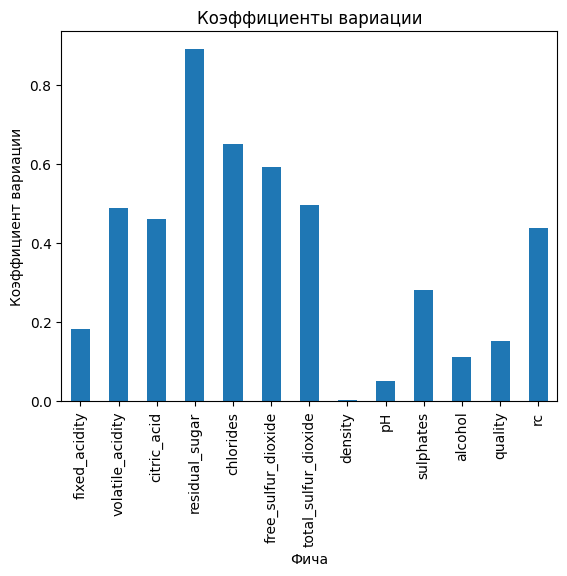

In [10]:
(df.std() / df.mean()).plot.bar(
    title='Коэффициенты вариации',
    xlabel='Фича',
    ylabel='Коэффициент вариации',
)

## Поиск аномалий

In [11]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,rc
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,1
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,1
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,1
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,1
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,1


In [12]:
base_cols = df.drop(
    columns=['quality','rc'],  # анализируем все фичи, кроме таргета и rc
).columns.tolist()

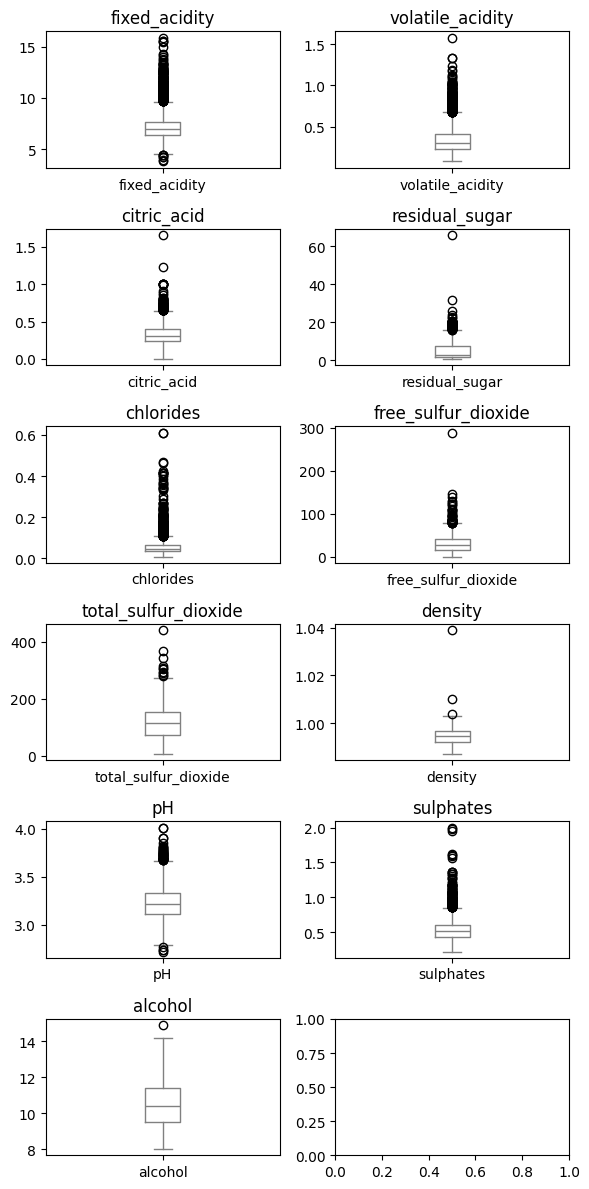

In [13]:
plot_boxplots(
    df,
    n_cols=2,
    features_list=base_cols,
    splot_height=2,
    splot_width=3,
)

In [14]:
col = 'fixed_acidity'

def get_outliers(ser: pd.Series, coef: float = 1.5) -> pd.Series:
    lims = ser.quantile(q=[0.25, 0.75])
    iqr = lims[0.75] - lims[0.25]
    upr_lim = lims[0.75] + coef * iqr
    lwr_lim = lims[0.25] - coef * iqr
    outliers = 0 * ser
    outliers[ser <= lwr_lim] = -1
    outliers[ser >= upr_lim] = 1
    return outliers
    
outliers_target = []
    
for col in base_cols:    
    tmp = df.quality.groupby(get_outliers(df[col])).value_counts(normalize=False).unstack()
    tmp['feature'] = col
    outliers_target.append(tmp)
    
outliers_target = pd.concat(outliers_target)
outliers_target.index.name = 'outlier_type'
# get_outliers(df[col]).value_counts()

# outliers_target.reset_index()
outliers_target = outliers_target.groupby(['feature','outlier_type']).sum()

In [15]:
outliers_cnt = outliers_target.sum(axis=1)[outliers_target.index.get_level_values(1)!=0]
outliers_cnt

feature               outlier_type
alcohol                1.0              1.0
chlorides              1.0            237.0
citric_acid            1.0            143.0
density                1.0              3.0
fixed_acidity         -1.0              7.0
                       1.0            297.0
free_sulfur_dioxide    1.0             44.0
pH                    -1.0              4.0
                       1.0             52.0
residual_sugar         1.0            145.0
sulphates              1.0            163.0
total_sulfur_dioxide   1.0             10.0
volatile_acidity       1.0            279.0
dtype: float64

In [16]:
outliers_target_pct = outliers_target.apply(lambda x: x / outliers_target.sum(axis=1)) * 100
outliers_target_pct = outliers_target_pct[
    (outliers_target_pct.index.get_level_values(1).isin([0,1]))&
    (
        outliers_target_pct.index.get_level_values(0).isin(
            outliers_cnt[outliers_cnt>=100].index.get_level_values(0)
        )
    )
]
# outliers_target_pct['feature'] = outliers_target['feature'].values


outliers_target_pct.style.background_gradient(cmap='Greens')

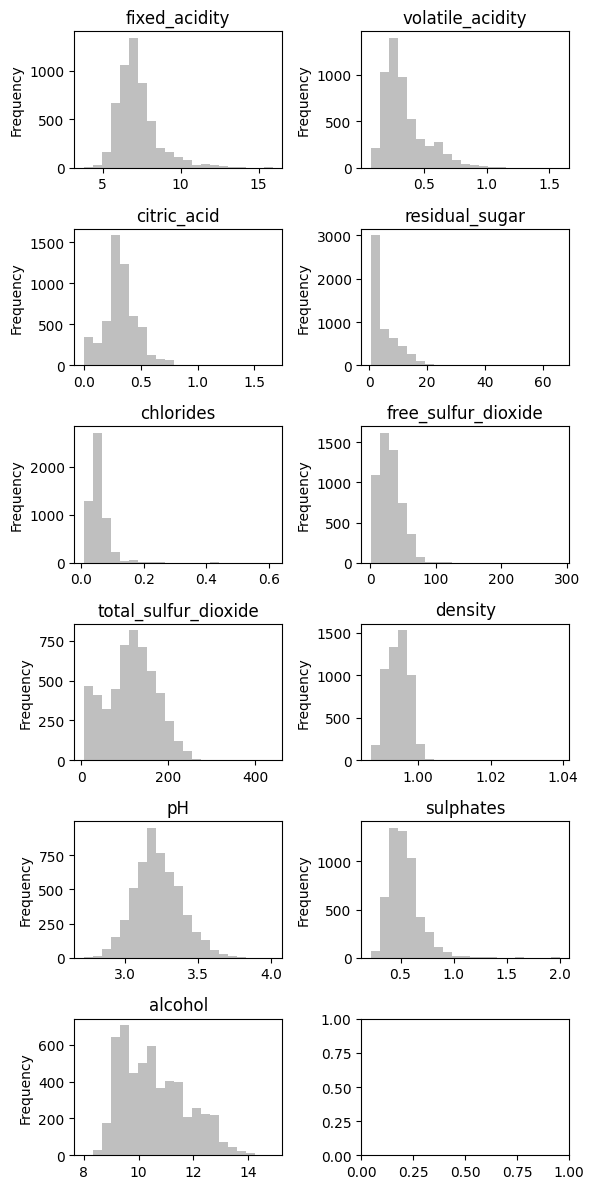

In [17]:
plot_distributions(
    df,
    n_cols=2,
    features_list=base_cols,
    splot_height=2,
    splot_width=3,
)

In [18]:
correls = df[base_cols].corr(method='spearman').reset_index().rename(columns={'index':'var_1'}).melt(
    id_vars='var_1',
    var_name='var_2',
    value_name='corr_coef',
).query("var_1 != var_2").copy()

correls[correls.corr_coef.abs()>=0.4]

,var_1,var_2,corr_coef
7,density,fixed_acidity,0.450159
15,chlorides,volatile_acidity,0.432606
39,total_sulfur_dioxide,residual_sugar,0.429006
40,density,residual_sugar,0.493473
45,volatile_acidity,chlorides,0.432606
51,density,chlorides,0.608802
54,alcohol,chlorides,-0.416988
61,total_sulfur_dioxide,free_sulfur_dioxide,0.741697
69,residual_sugar,total_sulfur_dioxide,0.429006
71,free_sulfur_dioxide,total_sulfur_dioxide,0.741697
